In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
import cosmoplots

from fppanalysis.running_moments import window_radius, run_norm_ds
from fppanalysis import conditional_averaging

from analysis_functions.constants import greenwald_fraction, shot_time_window
from analysis_functions.apd_functions import get_signal, get_time, get_rz, get_rz_full, get_dt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### This code plots the vertical blob size using the cross conditional average method
#### NB: To run this code, need to be on branch 'vertical_blob_size'

In [2]:
def find_fwhm_elements(array):
    """Function """
    # Convert the input to a NumPy array for efficient computation
    array_np = np.array(array)

    # Set dead pixels to zero
    array_np = np.nan_to_num(array_np)

    # Find the peak value and its index
    peak_index = np.argmax(array_np)
    peak_value = array_np[peak_index]
    half_max = peak_value / 2

    # Initialize indices for searching
    left_index = peak_index
    right_index = peak_index

    # Search to the left of the peak
    while left_index > 0 and array_np[left_index] > half_max:
        left_index -= 1
    # Adjust the left_index back to the point closest to the half_max
    if left_index > 0:
        left_index = left_index if abs(array_np[left_index] - half_max) < abs(array_np[left_index + 1] - half_max) else left_index + 1

    # Search to the right of the peak
    while right_index < len(array_np) - 1 and array_np[right_index] > half_max:
        right_index += 1
    # Adjust the right_index back to the point closest to the half_max
    if right_index < len(array_np) - 1:
        right_index = right_index if abs(array_np[right_index] - half_max) < abs(array_np[right_index - 1] - half_max) else right_index - 1

    return array_np[left_index], array_np[right_index], left_index, right_index

def vertical_blob_size(shot, init_x_pixel, init_y_pixel, num_tpts=None):

    t_start = shot_time_window[shot][0]
    t_end = shot_time_window[shot][1]
    path = Path('/Users/ahe104/Box/mfe_data/raw_apd_data')
    ds = xr.open_dataset(str(path) + '/' + f'apd_signal_array_{shot}.nc')

    path_dead_pixel = Path('/Users/ahe104/Box/mfe_data/dead_pixels')
    dead_pix = np.load(
        str(path_dead_pixel)
        + "/"
        + f"dead_pixels_shot_{shot}.npz"
    )
    dead_pix_arr = dead_pix['dead_pix_arr'] # Don't flip array, quiver plot is oriented this way
    dead_pix_arr_ds = dead_pix_arr[::-1,:] # Flip array to match ds['frames'] orientation
    for y in range(dead_pix_arr_ds.shape[0]):
        for x in range(dead_pix_arr_ds.shape[1]):
            if dead_pix_arr_ds[9-y, x]:
                ds['frames'].loc[dict(y=y, x=x)] = np.nan

    f_GW = greenwald_fraction[shot]
    t_start = shot_time_window[shot][0]
    t_end = shot_time_window[shot][1]

    sliced_ds = ds.sel(time=slice(t_start, t_end))
    radius = window_radius(1e3, sliced_ds.time)
    ds = run_norm_ds(sliced_ds, radius)

    R_coordinates, Z_coordinates = get_rz_full(ds)

    # Reference pixel
    data = get_signal(x=init_x_pixel, y=init_y_pixel, ds=ds)
    time = get_time(x=init_x_pixel, y=init_y_pixel, ds=ds)
    dt = get_dt(ds)

    # Vertical neighbour up
    data_up = get_signal(x=init_x_pixel, y=init_y_pixel+1, ds=ds)
    time_up = get_time(x=init_x_pixel, y=init_y_pixel+1, ds=ds)

    # Vertical neighbour down
    data_down = get_signal(x=init_x_pixel, y=init_y_pixel-1, ds=ds)
    time_down = get_time(x=init_x_pixel, y=init_y_pixel-1, ds=ds)

    Svals, _, _, _, peaks, peaks_time_base, _ = conditional_averaging.cond_av(
        data,
        time,
        2.5,
        delta=1.4e-4,
        window=True,
        print_verbose=False,
    )
    Svals_up, _, _, _, peaks_up, peaks_time_base_up, _ = conditional_averaging.cond_av(
        data_up,
        time_up,
        2.5,
        delta=1.4e-4,
        window=True,
        print_verbose=False,
    )
    Svals_down, _, _, _, peaks_down, peaks_time_base_down, _ = conditional_averaging.cond_av(
        data_down,
        time_down,
        2.5,
        delta=1.4e-4,
        window=True,
        print_verbose=False,
    )

    # List containing all time points where the given pixel has amplitude larger than above and below.
    max_peak_z = []
    max_peak_z_time = []
    max_peak_z_time_idx = []
    for idx, event in enumerate(peaks_time_base):
      # Time base index of peak point
      peak_time_idx = np.where(time == event)[0][0]
      if data[peak_time_idx] > data_up[peak_time_idx] and data[peak_time_idx] > data_down[peak_time_idx]:
        max_peak_z.append(peaks[idx])
        max_peak_z_time.append(peaks_time_base[idx])
        max_peak_z_time_idx.append(peak_time_idx)

    rows = 10
    f_Z_tpts = np.zeros((10, len(max_peak_z_time_idx)))
    for y_pixel in range(rows):
      Z_tpts = []
      # Loop through all time points where we have found peak that is larger than the pixel above and below
      for tpt_idx, tpt in enumerate(max_peak_z_time_idx):
        signal = get_signal(x=init_x_pixel, y=y_pixel, ds=ds)
        if len(signal) == 0:
          f_Z_tpts[y_pixel, tpt_idx] = np.nan
        else:
          f_Z_tpts[y_pixel, tpt_idx] = signal[tpt]

    f_Z_average = np.nanmean(f_Z_tpts, axis=1)

    f_Z_tpts_norm = f_Z_tpts / data[max_peak_z_time_idx]
    f_Z_average_norm = np.nanmean(f_Z_tpts_norm, axis=1)

    count = 0
    distances = []
    f_Z_mono = [] # Monotonically decreasing from peak:))

    if not num_tpts:
      num_tpts = len(max_peak_z_time_idx)

    for i in range(num_tpts):
      peak_value = max(f_Z_tpts[:,i])
      peak_idx = np.where(f_Z_tpts[:,i] == max(f_Z_tpts[:,i]))[0][0]
      if Z_coordinates[0][peak_idx] <= -3.50300002 or Z_coordinates[0][peak_idx] >= -1.58599997:
        #print(f_Z_tpts[:,i])
        # If peak is not in the reference pixel. Which could have been checked with this:
        # First, make sure that the peak is positioned at the reference pixel (= 'init_y_pixel')
        # if peak_idx == init_x_pixel:
        continue

      # Make sure that it has half maximum within two indcies away from peak
      if f_Z_tpts[:,i][peak_idx-2] <= (f_Z_tpts[:,i][peak_idx] / 2) and f_Z_tpts[:,i][peak_idx+2] <= (f_Z_tpts[:,i][peak_idx] / 2):
        count += 1
        f_Z_mono.append(f_Z_tpts[:,i])

    interpolation_pnts = 500
    distances = []

    # Generate colors for each pixel
    color_list = cosmoplots.generate_hex_colors(
        len(f_Z_mono), "plasma", show_swatch=False, ascending=True
    )

    interp_f_Z = []
    interp_f_Z_xvals = []
    #fig, ax = plt.subplots(1)
    for idx, func in enumerate(f_Z_mono):
      x = Z_coordinates[0]
      # Set dead pixels to zero
      y = np.nan_to_num(func)
      xvals = np.linspace(Z_coordinates[0][0], Z_coordinates[0][-1], interpolation_pnts)
      yinterp = np.interp(xvals, x, y)
      interp_f_Z.append(yinterp)
      interp_f_Z_xvals.append(xvals)

      # Find index at half maximum
      #element1, element2, idx1, idx2 = find_two_closest_elements(yinterp, np.max(yinterp)/2)
      left_value, right_value, left_index, right_index = find_fwhm_elements(yinterp)
      #ax.plot(xvals, yinterp, color=color_list[idx])
      #ax.scatter(xvals[right_index], yinterp[right_index], color=color_list[idx])
      #ax.scatter(xvals[left_index], yinterp[left_index], color=color_list[idx])
      #ax.set_xlim(left=Z_coordinates[0][-1]+0.15, right=Z_coordinates[0][0]-0.15)
      distances.append(np.abs(xvals[right_index] - xvals[left_index]))

    return distances, f_Z_mono, Z_coordinates

In [3]:
shotlist = [1110201016, 1110201011, 1160616018]
f_GWs = [greenwald_fraction[shot] for shot in shotlist]
marker_list = ['^', 'o', 'v']
color_list = ['#785EF0', '#DC267F', '#FFB000']
label_name = ['EDA H', 'ELM-free H', 'Ohmic']

init_x_pixel = 6
init_y_pixel = 4

interpolation_pnts = 500
distances_shotlist = {}
f_Z_shotlist = {}
f_Z_mean_shotlist = {}
f_Z_yinterp = {}
f_Z_xinterp = {}

for shot in shotlist:
  distances_dist, f_Z_mono, Z_coordinates = vertical_blob_size(shot, init_x_pixel, init_y_pixel)

  # Average of all events
  f_Z_mono_mean = np.nanmean(f_Z_mono, axis=0)

  # Interpolate
  x = Z_coordinates[0]
  y = np.nan_to_num(f_Z_mono_mean)
  xvals = np.linspace(Z_coordinates[0][0], Z_coordinates[0][-1], interpolation_pnts)
  yinterp = np.interp(xvals, x, y)# Set dead pixels to zero

  # Find FWHM
  left_value, right_value, left_index, right_index = find_fwhm_elements(yinterp)

  # Add to dictionary
  #distances_shotlist[shot] = {'distances': total_distances}
  distances_shotlist[shot] = {'distances': distances_dist}
  f_Z_shotlist[shot] = {'f_Z': f_Z_mono}
  f_Z_mean_shotlist[shot] = {'f_Z_mean': f_Z_mono_mean}
  f_Z_yinterp[shot] = {'f_Z_yinterp': yinterp, 'left_value': left_value, 'right_value': right_value, 'left_index': left_index, 'right_index': right_index}
  f_Z_xinterp[shot] = {'f_Z_xinterp': xvals}

1110201016: 0.62 cm
1110201011: 0.81 cm
1160616018: 0.69 cm


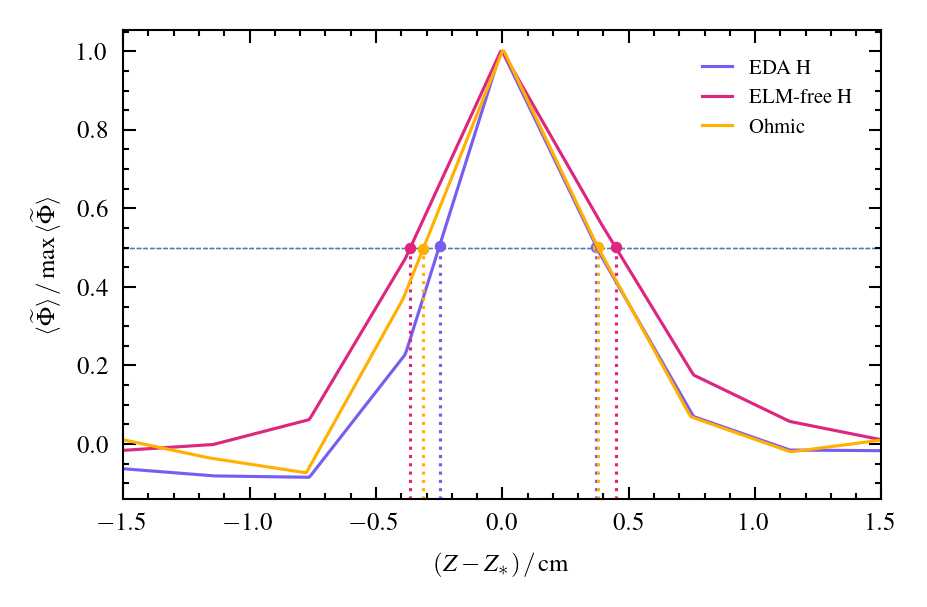

In [63]:
save = False

axes_size = cosmoplots.set_rcparams_dynamo(plt.rcParams, num_cols=1, ls="thin")
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["font.size"] = 6
plt.rcParams["legend.fontsize"] = 5
plt.rcParams["axes.labelsize"] = 6
plt.rcParams["xtick.labelsize"] = 6
plt.rcParams["ytick.labelsize"] = 6
plt.rcParams["xtick.major.size"] = 3
plt.rcParams["xtick.minor.size"] = 1.5
plt.rcParams["ytick.major.size"] = 3
plt.rcParams["ytick.minor.size"] = 1.5
plt.rcParams["ytick.minor.width"] = 0.5
plt.rcParams["xtick.minor.width"] = 0.5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["xtick.major.width"] = 0.5

fig = plt.figure()
ax = fig.add_axes(axes_size)

for idx, shot in enumerate(shotlist):
  x_plot = f_Z_xinterp[shot]['f_Z_xinterp']
  y_plot = f_Z_yinterp[shot]['f_Z_yinterp']
  y_plot_norm = y_plot / np.max(y_plot)

  # Find position of the maximum value
  x_norm_value = x_plot[np.where(y_plot == np.max(y_plot))[0][0]]

  # Normalize x-axis to its maximum y value position
  x_plot = x_plot - x_norm_value

  x_scatter_right = f_Z_xinterp[shot]['f_Z_xinterp'][f_Z_yinterp[shot]['right_index']]

  # Normalize
  x_scatter_right = x_scatter_right - x_norm_value

  y_scatter_right = f_Z_yinterp[shot]['f_Z_yinterp'][f_Z_yinterp[shot]['right_index']]
  y_scatter_right_norm = y_scatter_right / np.max(y_plot)

  x_scatter_left = f_Z_xinterp[shot]['f_Z_xinterp'][f_Z_yinterp[shot]['left_index']]

  # Normalize
  x_scatter_left = x_scatter_left - x_norm_value

  y_scatter_left = f_Z_yinterp[shot]['f_Z_yinterp'][f_Z_yinterp[shot]['left_index']]
  y_scatter_left_norm = y_scatter_left / np.max(y_plot)

  ax.plot(x_plot, y_plot_norm, label=label_name[idx], color=color_list[idx])
  ax.scatter(x_scatter_right, y_scatter_right_norm, color=color_list[idx])
  ax.scatter(x_scatter_left, y_scatter_left_norm, color=color_list[idx])

  # Plotting the horizontal dotted line
  x_start = Z_coordinates[0][0] - 0.35
  x_left = f_Z_xinterp[shot]['f_Z_xinterp'][f_Z_yinterp[shot]['left_index']] - x_norm_value
  x_right = f_Z_xinterp[shot]['f_Z_xinterp'][f_Z_yinterp[shot]['right_index']] - x_norm_value
  y_value = f_Z_yinterp[shot]['f_Z_yinterp'][f_Z_yinterp[shot]['left_index']]
  y_value_norm = y_value / np.max(y_value)

  ax.axhline(y=0.5, linestyle='--', color='steelblue', linewidth=0.3, zorder=0)
  ax.axvline(x=x_left, ymin=0, ymax=y_scatter_left_norm+.03, linestyle=':', color=color_list[idx])
  ax.axvline(x=x_right, ymin=0, ymax=y_scatter_right_norm+.03, linestyle=':', color=color_list[idx])

  print(f'{shotlist[idx]}: {np.round(np.abs(x_left - x_right),2)} cm')

ax.set_xlim(left=-1.5, right=1.5)
ax.set_xlabel(r'$(Z - Z_{\ast}) \,/\, \mathrm{cm} $')
ax.set_ylabel(r"$\langle \widetilde{\Phi} \rangle \,/\, \mathrm{max}\, \langle \widetilde{\Phi} \rangle$")
ax.legend(frameon=False, borderaxespad=1)

if save == True:
    format = "pdf"
    foldername = '/Users/ahe104/Box/time_delay_estimation/velocity_field/analysis/PSI/'
    filename = f'vertical_blob_size_init_x_{init_x_pixel}_init_y_{init_y_pixel}.{format}'
    fig.savefig(foldername + filename, bbox_inches="tight", format=format)
